# 1. INSTALL LIBRARIES

In [1]:
!apt-get update -qq && apt-get install -y -qq openbabel autodock-vina > /dev/null
print("Installation done: OpenBabel, AutoDock-Vina")

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
print("Installation done: Torch Modules")

!pip install -q transformers datasets lightgbm
!pip install -q selfies rdkit
print("Installations complete.")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Installation done: OpenBabel, AutoDock-Vina
Installation done: Torch Modules
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 49.9 MB/s eta 0:00:00
Installations complete.


# 2. IMPORTS & GLOBAL SETUP

In [2]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from transformers import (
    AutoTokenizer,
    GPTNeoForCausalLM,
    GPTNeoConfig,
)
from transformers.modeling_outputs import CausalLMOutputWithPast

from rdkit import Chem
import selfies as sf
from selfies import decoder
from tqdm.auto import tqdm

print("Libraries imported.")

# ---------- Config ----------
SFT_DATA_FILE_SELFIES = "combined_df_labeled_oversampled_(MOL_SELFIES).csv"

EGFR_EMB_FILE = "Upd_EGFR_embedding_residue.pt"
MET_EMB_FILE  = "Upd_MET_embedding_residue.pt"

BASE_MODEL = "ncfrey/ChemGPT-1.2B"
FINAL_MODEL_OUTPUT_DIR = "./AlphaGen_DualTarget_SFT_SELFIES"

MAX_LENGTH   = 128
BATCH_SIZE   = 8
LEARNING_RATE = 1e-6   # small but not insanely tiny
NUM_EPOCHS   = 25      # adjust as needed

# ---------- Device & Seeds ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

print(f"Using device: {device}")
print(f"LR = {LEARNING_RATE}")

Libraries imported.
Using device: cuda
LR = 1e-06


# 3. LOAD & CHECK PROTEIN EMBEDDINGS

In [3]:
def check_embedding(filename):
    print(f"Checking {filename} ...")
    try:
        emb = torch.load(filename, map_location="cpu")
        if not isinstance(emb, torch.Tensor):
            raise ValueError("File does not contain a torch.Tensor")

        # Basic stats
        has_nan = torch.isnan(emb).any().item()
        has_inf = torch.isinf(emb).any().item()
        mx = emb.max().item()
        mn = emb.min().item()
        std = emb.std().item()

        print(f"  Shape: {tuple(emb.shape)}")
        print(f"  Max: {mx:.6f}, Min: {mn:.6f}, Std: {std:.6f}")
        if has_nan or has_inf:
            print("  FATAL: NaN or Inf detected in embedding. Please regenerate.")
            return False
        if std < 1e-7:
            print("  FATAL: Near-zero variance embedding. Please regenerate.")
            return False
        print("  -> Embedding looks healthy.")
        return True
    except Exception as e:
        print(f"  Error loading {filename}: {e}")
        return False

if not check_embedding(EGFR_EMB_FILE):
    sys.exit(1)
if not check_embedding(MET_EMB_FILE):
    sys.exit(1)

# Load to device (float32)
egfr_emb = torch.load(EGFR_EMB_FILE, map_location=device).to(torch.float32)
met_emb  = torch.load(MET_EMB_FILE,  map_location=device).to(torch.float32)

# Concatenate along sequence (residue) dimension for dual-target conditioning
dual_emb = torch.cat([egfr_emb, met_emb], dim=1)  # [1, L_egfr + L_met, 384]

print(f"EGFR embedding shape: {egfr_emb.shape}")
print(f"MET  embedding shape: {met_emb.shape}")
print(f"DUAL embedding shape: {dual_emb.shape}")

Checking Upd_EGFR_embedding_residue.pt ...
  Shape: (1, 1210, 384)
  Max: 0.357171, Min: -0.323090, Std: 0.105548
  -> Embedding looks healthy.
Checking Upd_MET_embedding_residue.pt ...
  Shape: (1, 1390, 384)
  Max: 0.345276, Min: -0.322004, Std: 0.106325
  -> Embedding looks healthy.
EGFR embedding shape: torch.Size([1, 1210, 384])
MET  embedding shape: torch.Size([1, 1390, 384])
DUAL embedding shape: torch.Size([1, 2600, 384])


# 4. MODEL DEFINITION


In [4]:
class ProteinConditionedChemGPT(GPTNeoForCausalLM):
    """
    ChemGPT-4.7M with **manual, numerically-safe cross-attention**
    conditioning on protein residue embeddings.
    """

    def __init__(self, config: GPTNeoConfig, **kwargs):
        super().__init__(config)
        hidden_size = config.hidden_size
        num_heads   = config.num_heads

        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        self.hidden_size = hidden_size
        self.num_heads   = num_heads
        self.head_dim    = hidden_size // num_heads

        # AlphaFold residue embeddings are 384-dim
        self.protein_dim = 384

        # Project protein embeddings -> hidden_size
        self.protein_proj = nn.Linear(self.protein_dim, hidden_size)

        # Q/K/V projections for cross-attention
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)

        # Output projection
        self.out_proj = nn.Linear(hidden_size, hidden_size)

        # Normalization layers
        self.protein_ln = nn.LayerNorm(hidden_size)
        self.query_ln   = nn.LayerNorm(hidden_size)
        self.attn_ln    = nn.LayerNorm(hidden_size)

        # Residual scaling – start extremely small
        self.attn_scale = nn.Parameter(torch.tensor(0.001, dtype=torch.float32))

        # Extra: initialize new layers with a smaller std for safety
        for m in [self.protein_proj, self.q_proj, self.k_proj, self.v_proj, self.out_proj]:
            nn.init.normal_(m.weight, mean=0.0, std=0.005)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # ---------- Safe cross-attention op ----------
    def _protein_cross_attend(self, hidden_states, protein_emb):
        """
        hidden_states: [B, T, H]
        protein_emb:   [B, Lp, 384] or [1, Lp, 384]
        returns:       [B, T, H] (residual added outside)
        """

        B, T, H = hidden_states.shape

        # Make sure protein has batch dim
        if protein_emb.dim() == 2:
            protein_emb = protein_emb.unsqueeze(0)   # [1, Lp, 384]

        if protein_emb.size(0) == 1 and B > 1:
            protein_emb = protein_emb.expand(B, -1, -1)  # broadcast

        # 1) Project protein embeddings -> hidden, then normalize
        #    [B, Lp, 384] -> [B, Lp, H]
        protein_ctx = self.protein_proj(protein_emb)
        protein_ctx = self.protein_ln(protein_ctx)

        # 2) Normalize query (ligand states)
        query = self.query_ln(hidden_states)  # [B, T, H]

        # 3) Q/K/V projections
        #    [B, T, H] / [B, Lp, H] -> [B, T, H] etc.
        q = self.q_proj(query)
        k = self.k_proj(protein_ctx)
        v = self.v_proj(protein_ctx)

        # 4) Reshape to multi-head: [B, T, H] -> [B, nH, T, dH]
        def split_heads(x, B, L):
            return x.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
            # -> [B, nH, L, dH]

        q = split_heads(q, B, T)                 # [B, nH, T, dH]
        k = split_heads(k, B, protein_ctx.size(1))  # [B, nH, Lp, dH]
        v = split_heads(v, B, protein_ctx.size(1))  # [B, nH, Lp, dH]

        # 5) Scaled dot-product attention with clamping for stability
        # scores: [B, nH, T, Lp]
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # clamp scores to a safe range to avoid exp overflow in softmax
        scores = torch.clamp(scores, min=-50.0, max=50.0)

        attn_weights = F.softmax(scores, dim=-1)

        # if any row is all -inf, softmax can still produce NaNs -> guard
        attn_weights = torch.where(
            torch.isnan(attn_weights),
            torch.zeros_like(attn_weights),
            attn_weights,
        )

        # 6) Attention output
        # [B, nH, T, Lp] @ [B, nH, Lp, dH] -> [B, nH, T, dH]
        context = torch.matmul(attn_weights, v)

        # 7) Merge heads: [B, nH, T, dH] -> [B, T, H]
        context = context.transpose(1, 2).contiguous().view(B, T, H)

        # 8) Output projection + LayerNorm
        out = self.out_proj(context)
        out = self.attn_ln(out)

        return out

    # ---------- Forward ----------
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        protein_emb=None,
        labels=None,
        **kwargs,
    ):
        if input_ids is None:
            raise ValueError("input_ids must be provided")

        # 1) Base ChemGPT transformer -> hidden states
        transformer_outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=False,
            **kwargs,
        )
        hidden_states = transformer_outputs.last_hidden_state   # [B, T, H]

        # Quick sanity check: base model should never produce NaN/Inf
        if torch.isnan(hidden_states).any() or torch.isinf(hidden_states).any():
            print("[DEBUG] NaN/Inf in hidden_states right after base transformer.")
            # If this ever prints, the problem is NOT cross-attn.

        # 2) Protein-conditioned cross-attention
        if protein_emb is not None:
            cross_out = self._protein_cross_attend(hidden_states, protein_emb)

            if torch.isnan(cross_out).any() or torch.isinf(cross_out).any():
                print("[DEBUG] NaN/Inf in cross_out BEFORE residual add.")
            # Residual add with small learnable scale
            hidden_states = hidden_states + self.attn_scale * cross_out

            if torch.isnan(hidden_states).any() or torch.isinf(hidden_states).any():
                print("[DEBUG] NaN/Inf in hidden_states AFTER cross-attn residual.")

        # 3) LM head for logits
        lm_logits = self.lm_head(hidden_states)

        if torch.isnan(lm_logits).any() or torch.isinf(lm_logits).any():
            print("[DEBUG] NaN/Inf in lm_logits before loss.")

        loss = None
        if labels is not None:
            # autoregressive shift
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
            )

        return CausalLMOutputWithPast(
            loss=loss,
            logits=lm_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )


# 5. TOKENIZER & MODEL INITIALIZATION

In [6]:
print("Loading ChemGPT-4.7M tokenizer & base model ...")

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    print("Added [PAD] token to tokenizer.")

# Load into our subclass
model = ProteinConditionedChemGPT.from_pretrained(BASE_MODEL)
model.resize_token_embeddings(len(tokenizer))

model.to(device)
model.train()

# For debugging: NO gradient checkpointing at first
model.config.use_cache = False
# model.gradient_checkpointing_enable()   # <-- comment this out for now

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,       # 1e-5 is fine once the forward is numerically safe
    weight_decay=0.01,
)

print("Model initialized.")

Loading ChemGPT-4.7M tokenizer & base model ...
Added [PAD] token to tokenizer.


Some weights of ProteinConditionedChemGPT were not initialized from the model checkpoint at ncfrey/ChemGPT-1.2B and are newly initialized: ['attn_ln.bias', 'attn_ln.weight', 'attn_scale', 'k_proj.bias', 'k_proj.weight', 'out_proj.bias', 'out_proj.weight', 'protein_ln.bias', 'protein_ln.weight', 'protein_proj.bias', 'protein_proj.weight', 'q_proj.bias', 'q_proj.weight', 'query_ln.bias', 'query_ln.weight', 'v_proj.bias', 'v_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized.


# 6. DATASET (SELFIES) & SAMPLER

In [7]:
class ConditionalSelfiesDataset(Dataset):
    """
    Returns:
      - input_ids: tokenized SELFIES sequence
      - labels: same as input_ids but pad tokens -> -100
      - protein_emb: EGFR / MET / DUAL embedding (per label)
    """

    def __init__(self, df: pd.DataFrame, tokenizer, egfr_emb, met_emb, dual_emb, max_len=128):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

        # detect selfies column
        selfies_candidates = [
            "canonical_selfies", "selfies", "SELFIES",
            "mol_selfies", "MOL_SELFIES", "SELFIES_STRING"
        ]
        self.selfies_col = None
        for c in selfies_candidates:
            if c in self.df.columns:
                self.selfies_col = c
                break
        if self.selfies_col is None:
            raise ValueError(
                f"Could not find a SELFIES column in CSV. "
                f"Tried: {selfies_candidates}. Available: {list(self.df.columns)}"
            )
        if "target_label" not in self.df.columns:
            raise ValueError("'target_label' column missing in dataset.")

        self.labels = self.df["target_label"].astype(int).values

        # store protein embeddings on device
        self.egfr_emb = egfr_emb.to(device)
        self.met_emb  = met_emb.to(device)
        self.dual_emb = dual_emb.to(device)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        label = int(row["target_label"])

        selfies_str = str(row[self.selfies_col])

        # safety fallback
        if selfies_str.lower() == "nan" or len(selfies_str.strip()) == 0:
            selfies_str = "[C]"  # trivial molecule

        # Tokenize SELFIES as text
        enc = self.tokenizer(
            selfies_str,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)  # [seq_len]

        # Labels: same as input_ids but pad token -> -100
        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        # Pick protein embedding
        if label == 0:
            prot = self.egfr_emb  # [1, L1, 384]
        elif label == 1:
            prot = self.met_emb   # [1, L2, 384]
        elif label == 2:
            prot = self.dual_emb  # [1, L1+L2, 384]
        else:
            raise ValueError(f"Unexpected target_label {label}. Expected 0,1,2.")

        prot = prot.squeeze(0)  # [L, 384]

        return {
            "input_ids": input_ids.to(device),
            "labels": labels.to(device),
            "protein_emb": prot.to(device),
            "target_label": torch.tensor(label, dtype=torch.long, device=device),
        }


class GroupedBatchSampler(Sampler):
    """
    Ensures each batch contains only one target_label
    so stacked protein_emb have identical sequence length.
    """

    def __init__(self, labels, batch_size):
        self.labels = np.array(labels)
        self.batch_size = batch_size

        self.group_indices = {
            lab: np.where(self.labels == lab)[0]
            for lab in np.unique(self.labels)
        }

        self.batches = []
        for lab, indices in self.group_indices.items():
            indices = indices.copy()
            np.random.shuffle(indices)
            num = math.ceil(len(indices) / self.batch_size)
            for i in range(num):
                start = i * self.batch_size
                end = min(start + self.batch_size, len(indices))
                self.batches.append(indices[start:end])

        # shuffle global batch order
        np.random.shuffle(self.batches)

    def __iter__(self):
        np.random.shuffle(self.batches)
        for b in self.batches:
            yield b

    def __len__(self):
        return len(self.batches)

# 7. LOAD DATA & CREATE DATALOADER

In [8]:
print(f"Loading SFT data from {SFT_DATA_FILE_SELFIES} ...")
if not os.path.exists(SFT_DATA_FILE_SELFIES):
    raise FileNotFoundError(f"{SFT_DATA_FILE_SELFIES} not found in current directory.")

sft_df = pd.read_csv(SFT_DATA_FILE_SELFIES)
print(f"Loaded {len(sft_df)} samples.")
print(sft_df.head())

train_dataset = ConditionalSelfiesDataset(
    df=sft_df,
    tokenizer=tokenizer,
    egfr_emb=egfr_emb,
    met_emb=met_emb,
    dual_emb=dual_emb,
    max_len=MAX_LENGTH,
)

train_sampler = GroupedBatchSampler(
    labels=sft_df["target_label"].values,
    batch_size=BATCH_SIZE,
)

def collate_fn(batch):
    # batch: list of dicts
    batch_out = {}
    for key in batch[0].keys():
        if key == "protein_emb":
            # each is [L, 384], all same L within batch
            batch_out[key] = torch.stack([b[key] for b in batch], dim=0)
        else:
            batch_out[key] = torch.stack([b[key] for b in batch], dim=0)
    return batch_out

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    collate_fn=collate_fn,
)

print("DataLoader ready.")

Loading SFT data from combined_df_labeled_oversampled_(MOL_SELFIES).csv ...
Loaded 4139 samples.
                                             selfies  target_label
0  [Cl].[2H][C][Branch1][C][2H][Branch2][Ring2][=...             2
1  [C][=C][C][=Branch1][C][=O][N][C][=C][C][=C][N...             0
2  [F][C][=C][C][=C][Branch2][Ring1][C][N][C][=N]...             0
3  [C][O][C][=C][C][=N][C][=N][C][Branch1][S][N][...             0
4  [O][=C][/N][=C][\N][C][=C][C][=C][C][=C][Ring1...             0
DataLoader ready.


# 8. TRAINING LOOP (with stability checks)

In [9]:
def train_with_stability(model, loader, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
        progress = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)

        total_loss = 0.0
        valid_batches = 0

        # enable anomaly detection only for epoch 1
        anomaly = (epoch == 0)
        if anomaly:
            torch.autograd.set_detect_anomaly(True)

        for step, batch in enumerate(progress):
            input_ids   = batch["input_ids"]
            labels      = batch["labels"]
            protein_emb = batch["protein_emb"]

            if (torch.isnan(input_ids).any() or torch.isinf(input_ids).any() or
                torch.isnan(labels).any()    or torch.isinf(labels).any()    or
                torch.isnan(protein_emb).any() or torch.isinf(protein_emb).any()):
                print(f"[WARN] NaN/Inf in batch tensors at step {step}; skipping.")
                continue

            optimizer.zero_grad(set_to_none=True)

            outputs = model(
                input_ids=input_ids,
                attention_mask=None,
                protein_emb=protein_emb,
                labels=labels,
            )
            loss = outputs.loss

            if loss is None:
                print(f"[WARN] Loss is None at step {step}, skipping batch.")
                continue
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"[WARN] NaN/Inf loss at step {step}, skipping batch.")
                continue

            loss.backward()

            # gradient sanity check
            bad_grad = False
            for name, p in model.named_parameters():
                if p.grad is None:
                    continue
                if torch.isnan(p.grad).any() or torch.isinf(p.grad).any():
                    print(f"[WARN] NaN/Inf in grad of {name} at step {step}")
                    bad_grad = True
                    break
            if bad_grad:
                optimizer.zero_grad(set_to_none=True)
                continue

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            valid_batches += 1

            progress.set_postfix({"loss": f"{total_loss/valid_batches:.4f}"})

        if valid_batches > 0:
            print(f"Epoch {epoch+1} average loss: {total_loss/valid_batches:.4f}")
        else:
            print("No valid batches this epoch.")

In [10]:
print("Starting training ...")
train_with_stability(model, train_loader, optimizer, NUM_EPOCHS)
print("Training complete.")

Starting training ...

===== Epoch 1/25 =====


Epoch 1:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 1 average loss: 1.2248

===== Epoch 2/25 =====


Epoch 2:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 2 average loss: 0.7749

===== Epoch 3/25 =====


Epoch 3:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 3 average loss: 0.6631

===== Epoch 4/25 =====


Epoch 4:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 4 average loss: 0.5961

===== Epoch 5/25 =====


Epoch 5:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 5 average loss: 0.5444

===== Epoch 6/25 =====


Epoch 6:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 6 average loss: 0.5046

===== Epoch 7/25 =====


Epoch 7:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 7 average loss: 0.4698

===== Epoch 8/25 =====


Epoch 8:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 8 average loss: 0.4420

===== Epoch 9/25 =====


Epoch 9:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 9 average loss: 0.4186

===== Epoch 10/25 =====


Epoch 10:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 10 average loss: 0.3940

===== Epoch 11/25 =====


Epoch 11:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 11 average loss: 0.3749

===== Epoch 12/25 =====


Epoch 12:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 12 average loss: 0.3581

===== Epoch 13/25 =====


Epoch 13:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 13 average loss: 0.3411

===== Epoch 14/25 =====


Epoch 14:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 14 average loss: 0.3285

===== Epoch 15/25 =====


Epoch 15:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 15 average loss: 0.3134

===== Epoch 16/25 =====


Epoch 16:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 16 average loss: 0.3010

===== Epoch 17/25 =====


Epoch 17:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 17 average loss: 0.2902

===== Epoch 18/25 =====


Epoch 18:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 18 average loss: 0.2832

===== Epoch 19/25 =====


Epoch 19:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 19 average loss: 0.2736

===== Epoch 20/25 =====


Epoch 20:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 20 average loss: 0.2651

===== Epoch 21/25 =====


Epoch 21:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 21 average loss: 0.2575

===== Epoch 22/25 =====


Epoch 22:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 22 average loss: 0.2485

===== Epoch 23/25 =====


Epoch 23:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 23 average loss: 0.2446

===== Epoch 24/25 =====


Epoch 24:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 24 average loss: 0.2369

===== Epoch 25/25 =====


Epoch 25:   0%|          | 0/519 [00:00<?, ?it/s]

Epoch 25 average loss: 0.2335
Training complete.


# 9. SAVE MODEL & TOKENIZER

In [11]:
print(f"Saving fine-tuned model to {FINAL_MODEL_OUTPUT_DIR} ...")

os.makedirs(FINAL_MODEL_OUTPUT_DIR, exist_ok=True)

model.save_pretrained(FINAL_MODEL_OUTPUT_DIR)
tokenizer.save_pretrained(FINAL_MODEL_OUTPUT_DIR)

print("Save complete.")


Saving fine-tuned model to ./AlphaGen_DualTarget_SFT_SELFIES ...


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Save complete.


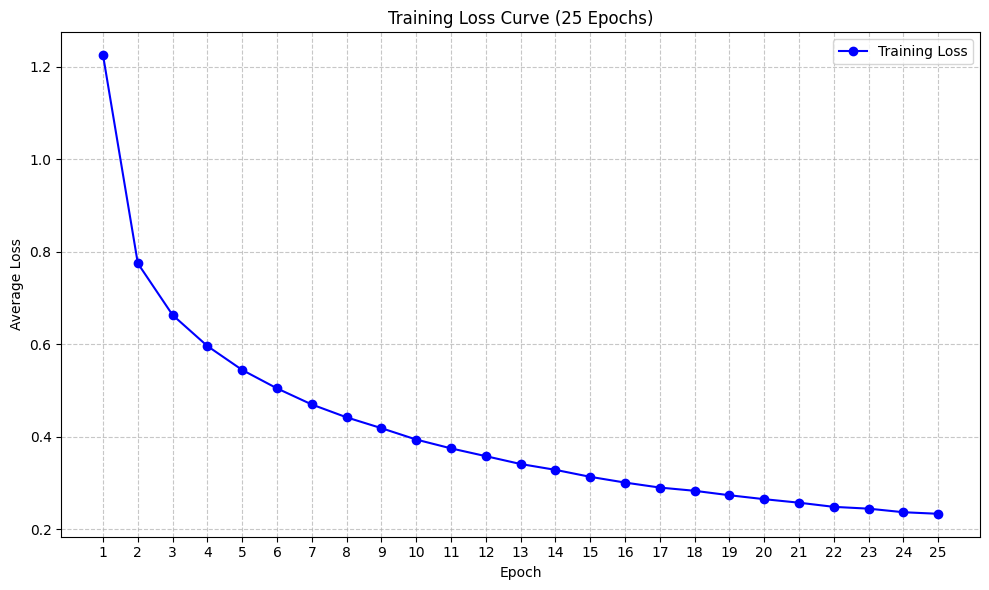

In [17]:
import matplotlib.pyplot as plt

# Losses extracted from the training output log
epoch_losses = [
    1.2248, 0.7749, 0.6631, 0.5961, 0.5444,
    0.5046, 0.4698, 0.4420, 0.4186, 0.3940,
    0.3749, 0.3581, 0.3411, 0.3285, 0.3134,
    0.3010, 0.2902, 0.2832, 0.2736, 0.2651,
    0.2575, 0.2485, 0.2446, 0.2369, 0.2335
]

epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Training Loss Curve (25 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks(epochs)  # Show all epoch numbers
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
def calculate_accuracy(model, loader, device):
    model.eval()
    total_correct = 0
    total_tokens = 0

    print("Calculating accuracy...")
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=True):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            protein_emb = batch["protein_emb"].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                protein_emb=protein_emb,
                labels=labels
            )

            # Get predictions
            logits = outputs.logits
            # Shift logits and labels for next-token prediction
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            predictions = torch.argmax(shift_logits, dim=-1)

            # Create mask for valid labels (ignore -100)
            mask = (shift_labels != -100)

            # Calculate correct predictions only on masked positions
            correct = (predictions == shift_labels) & mask

            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()

    accuracy = total_correct / total_tokens if total_tokens > 0 else 0.0
    return accuracy

train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"\nTraining Token Accuracy: {train_accuracy:.2%}")

Calculating accuracy...


Evaluating:   0%|          | 0/519 [00:00<?, ?it/s]


Training Token Accuracy: 92.58%


In [19]:
from rdkit.Chem import Descriptors, QED
import pandas as pd

# 1. Prepare Training Data Reference (for Novelty calculation)
# We need to convert training SELFIES to canonical SMILES to compare accurately.
print("Converting training SELFIES to SMILES for novelty check (this may take a moment)...")

train_smiles_set = set()
for s in tqdm(sft_df["selfies"].values, desc="Processing Training Data"):
    try:
        # Basic cleaning
        if isinstance(s, str) and len(s) > 0:
            sm = sf.decoder(s)
            mol = Chem.MolFromSmiles(sm)
            if mol:
                train_smiles_set.add(Chem.MolToSmiles(mol, isomericSmiles=False))
    except:
        continue

print(f"Reference training set size: {len(train_smiles_set)} unique SMILES.")

Converting training SELFIES to SMILES for novelty check (this may take a moment)...


Processing Training Data:   0%|          | 0/4139 [00:00<?, ?it/s]

Reference training set size: 3097 unique SMILES.


In [20]:
def evaluate_generation(model, tokenizer, protein_emb, reference_set, num_samples=50, device=device):
    """
    Generates molecules and calculates Validity, Uniqueness, Novelty, QED, and LogP.
    """
    generated_smiles = []
    valid_mols = []

    print(f"\nGenerating {num_samples} samples...")
    for _ in tqdm(range(num_samples), leave=False):
        # Generate
        s_str = generate_selfies(model, tokenizer, protein_emb, max_length=MAX_LENGTH, device=device)

        # Decode
        sm = selfies_to_smiles(s_str)
        if sm:
            mol = Chem.MolFromSmiles(sm)
            if mol:
                valid_mols.append(mol)
                generated_smiles.append(Chem.MolToSmiles(mol, isomericSmiles=False))

    # 1. Validity
    validity = len(valid_mols) / num_samples

    if len(valid_mols) == 0:
        return {"Validity": 0.0}

    # 2. Uniqueness
    unique_smiles = set(generated_smiles)
    uniqueness = len(unique_smiles) / len(generated_smiles)

    # 3. Novelty
    novel_smiles = unique_smiles - reference_set
    novelty = len(novel_smiles) / len(unique_smiles) if len(unique_smiles) > 0 else 0.0

    # 4. Properties (Average)
    qed_scores = [QED.qed(m) for m in valid_mols]
    logp_scores = [Descriptors.MolLogP(m) for m in valid_mols]
    mw_scores = [Descriptors.MolWt(m) for m in valid_mols]

    avg_qed = sum(qed_scores) / len(qed_scores)
    avg_logp = sum(logp_scores) / len(logp_scores)
    avg_mw = sum(mw_scores) / len(mw_scores)

    metrics = {
        "Validity": validity,
        "Uniqueness": uniqueness,
        "Novelty": novelty,
        "Avg_QED": avg_qed,
        "Avg_LogP": avg_logp,
        "Avg_MW": avg_mw
    }
    return metrics

In [21]:
# Run evaluation on EGFR target as an example
metrics_egfr = evaluate_generation(
    model=model,
    tokenizer=tokenizer,
    protein_emb=egfr_emb,
    reference_set=train_smiles_set,
    num_samples=100  # Adjust as needed
)

print("\n--- EGFR Generation Metrics ---")
for k, v in metrics_egfr.items():
    print(f"{k:<15}: {v:.4f}")


Generating 100 samples...


  0%|          | 0/100 [00:00<?, ?it/s]

[WARN] SELFIES->SMILES decode failed: invalid symbol ' [C]'
	SELFIES: [N] [C] [C] [N] [C] [C] [C] [N] [C] [=C] [Branch2] [Ring1] [C] [C] [=N] [C] [=N] [C] [=C] [Branch1] [=Branch1] [C] [Branch1] [C] [C] [Ring1] [=Branch2] [O] [Ring1] [#C] [C] [=C] [Ring2] [Ring1] [Branch1]+1] [C] [C] [C] [C] [Ring2] [Ring1] [P]+1]ch1]ch1]+2]ch1]ch1]ch1]ch1]ch1] [C] [C] [C] [C] [Ring2] [Ring1] [P]ch2]ch2]
[WARN] SELFIES->SMILES decode failed: invalid symbol ' [=C]'
	SELFIES: ##-HH+1]] [C] [=C] [Branch1] [=Branch1] [C] [Ring1] [#Branch1] [O] [C] [C] [C] [C] [N] [C] [=Branch1] [C] [=O] [C] [=C] [C] [C] [Ring1] [=N] [N] [C] [C] [Ring2] [Ring1] [#Branch1] [=C] [C] [=C] [C] [=C] [Branch1] [C] [F] [C] [Ring1] [#Branch1]ch1]ch1]ch1] [C] [Ring2] [Ring1] [=N]ch1]ch1]ch2]ch1]ch1]ch2]ch1] [C]ch1] [C] [Ring2] [Ring1] [P]ch1]ch1]ch2]ch1] [C] [C]
[WARN] SELFIES->SMILES decode failed: invalid symbol ' [Branch1]'
	SELFIES: ##-1]]+1]21] [C] [Branch1] [C] [C] [=C] [C] [=C] [Branch1] [N] [C] [=C] [C] [=N] [C] [=C] [Branch

# 10. MOLECULE GENERATION FUNCTIONS

In [22]:
def generate_selfies(
    model,
    tokenizer,
    protein_emb,
    max_length=128,
    temperature=0.8,
    top_k=50,
    top_p=0.95,
    device=device,
):
    model.eval()

    # ensure batch dim for protein
    if protein_emb.dim() == 2:
        protein_emb = protein_emb.unsqueeze(0)
    protein_emb = protein_emb.to(device)

    # start token
    if tokenizer.bos_token_id is not None:
        start_token_id = tokenizer.bos_token_id
    elif tokenizer.cls_token_id is not None:
        start_token_id = tokenizer.cls_token_id
    else:
        start_token_id = tokenizer.encode("C", add_special_tokens=False)[0]

    input_ids = torch.tensor([[start_token_id]], device=device, dtype=torch.long)

    generated_ids = []

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(
                input_ids=input_ids,
                protein_emb=protein_emb,
            )
            logits = outputs.logits[:, -1, :]  # [1, vocab]

            # temperature
            logits = logits / temperature

            # top-k
            if top_k > 0:
                topk_vals, _ = torch.topk(logits, top_k)
                thresh = topk_vals[:, -1].unsqueeze(-1)
                logits = torch.where(logits < thresh, torch.full_like(logits, -float("inf")), logits)

            # top-p
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumprobs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumprobs > top_p
                # shift right to keep first above threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = -float("inf")

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            next_id = next_token.item()

            generated_ids.append(next_id)
            input_ids = torch.cat([input_ids, next_token], dim=1)

            if next_id == tokenizer.eos_token_id or next_id == tokenizer.pad_token_id:
                break

    selfies_str = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return selfies_str


def selfies_to_smiles(selfies_str: str):
    try:
        smiles = sf.decoder(selfies_str)
        return smiles
    except Exception as e:
        print(f"[WARN] SELFIES->SMILES decode failed: {e}")
        return None


def generate_and_validate(model, tokenizer, protein_emb, max_length=128, label_name=""):
    selfies_str = generate_selfies(
        model,
        tokenizer,
        protein_emb,
        max_length=max_length,
    )
    print(f"[{label_name}] Generated SELFIES: {selfies_str}")

    smiles = selfies_to_smiles(selfies_str)
    if smiles is None:
        print(f"[{label_name}] Could not decode SELFIES to SMILES.")
        return

    print(f"[{label_name}] SMILES: {smiles}")

    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        print(f"[{label_name}] Valid molecule.")
    else:
        print(f"[{label_name}] Invalid SMILES (model needs more training).")

11. Generate Molecules for EGFR, MET, DUAL

In [23]:
print("\n--- Generate molecule conditioned on EGFR ---")
generate_and_validate(model, tokenizer, egfr_emb, max_length=MAX_LENGTH, label_name="EGFR")

print("\n--- Generate molecule conditioned on MET ---")
generate_and_validate(model, tokenizer, met_emb, max_length=MAX_LENGTH, label_name="MET")

print("\n--- Generate molecule conditioned on DUAL (EGFR+MET) ---")
generate_and_validate(model, tokenizer, dual_emb, max_length=MAX_LENGTH, label_name="DUAL")


--- Generate molecule conditioned on EGFR ---
[EGFR] Generated SELFIES: [N] [C] [C] [N] [C] [C] [N] [C] [C] [=C] [Branch2] [Ring1] [C] [C] [=N] [C] [=N] [C] [Branch1] [=Branch1] [C] [C] [C] [Ring1] [#Branchingng1] [O] [Ring1] [#Branch2] [C] [=C] [C] [Branch1] [N] [C] [Branch1] [C] [C] [C] [C] [Branch1] [C] [C] [C] [C] [Ring1] [#Branch1]ch1]ng2]ch1] [=N] [Ring2] [Ring1] [Ring1] [Ring1] [N]ch2] [Cl]ch1] [C] [C] [C] [Ring1] [P] [Ring1] [P]ch2]ch2]ch1]ch1]ch1] [C]
[WARN] SELFIES->SMILES decode failed: invalid symbol ' [C]'
	SELFIES: [N] [C] [C] [N] [C] [C] [N] [C] [C] [=C] [Branch2] [Ring1] [C] [C] [=N] [C] [=N] [C] [Branch1] [=Branch1] [C] [C] [C] [Ring1] [#Branchingng1] [O] [Ring1] [#Branch2] [C] [=C] [C] [Branch1] [N] [C] [Branch1] [C] [C] [C] [C] [Branch1] [C] [C] [C] [C] [Ring1] [#Branch1]ch1]ng2]ch1] [=N] [Ring2] [Ring1] [Ring1] [Ring1] [N]ch2] [Cl]ch1] [C] [C] [C] [Ring1] [P] [Ring1] [P]ch2]ch2]ch1]ch1]ch1] [C]
[EGFR] Could not decode SELFIES to SMILES.

--- Generate molecule condi